In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('poster')  # noqa
import dash_bio as dashbio
from python.cogtext.datasets.pubmed import PubMedDataLoader
from python.cogtext.similarity_matrix import get_similarity_matrix

# load weights, clusters and metadata (takes <20sec)

clusters = pd.read_csv('models/cogtext/abstracts_clusters.csv.gz', index_col=0)
weights = np.load('models/cogtext/abstracts_weights.npz')['arr_0']
clusters['weights'] = list(weights)

pubmed = PubMedDataLoader(preprocessed=False, drop_low_occurred_labels=True).load()
pubmed = pubmed.merge(clusters, on='pmid', how='left')

pubmed.dropna(subset=['cluster'], inplace=True)

In [2]:
n_popular_labels = 20
popular_labels = (pubmed.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_popular_labels)
                        .index.get_level_values('label').to_list())

In [3]:
from sklearn.preprocessing import StandardScaler
from python.cogtext.similarity_matrix import multivariate_normal_kl
from tqdm import tqdm

X = pubmed.groupby('label')['weights'].apply(lambda x: np.stack(x))

# tasks = pubmed.query('category.str.contains("Task")')['label'].unique()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

def multivariate_normal_kl(p, q):
  P = tfd.MultivariateNormalDiag(p.mean(axis=0), scale_diag=p.std(axis=0))
  Q = tfd.MultivariateNormalDiag(q.mean(axis=0), scale_diag=q.std(axis=0))

  # alternatively use independent normals for each dimension
  # P = tfd.Normal(p.mean(axis=0), p.std(axis=0))
  # Q = tfd.Normal(q.mean(axis=0), q.std(axis=0))

  return tfd.kl_divergence(P, Q).numpy()

kl_losses = np.zeros((X.shape[0], X.shape[0]))

for i,xi in tqdm(enumerate(X), total=X.shape[0]):
  for j,xj in enumerate(X):
    kl_losses[i,j] = multivariate_normal_kl(xi, xj)

kl_losses = pd.DataFrame(kl_losses, X.index, X.index)
kl_losses.to_csv('models/cogtext/multivariate_normal_kl_losses.csv')

max_kl_loss = kl_losses.replace([np.inf],0).max().max()
kl_losses.replace([np.inf, np.nan], max_kl_loss, inplace=True)

## Tasks and constructs together

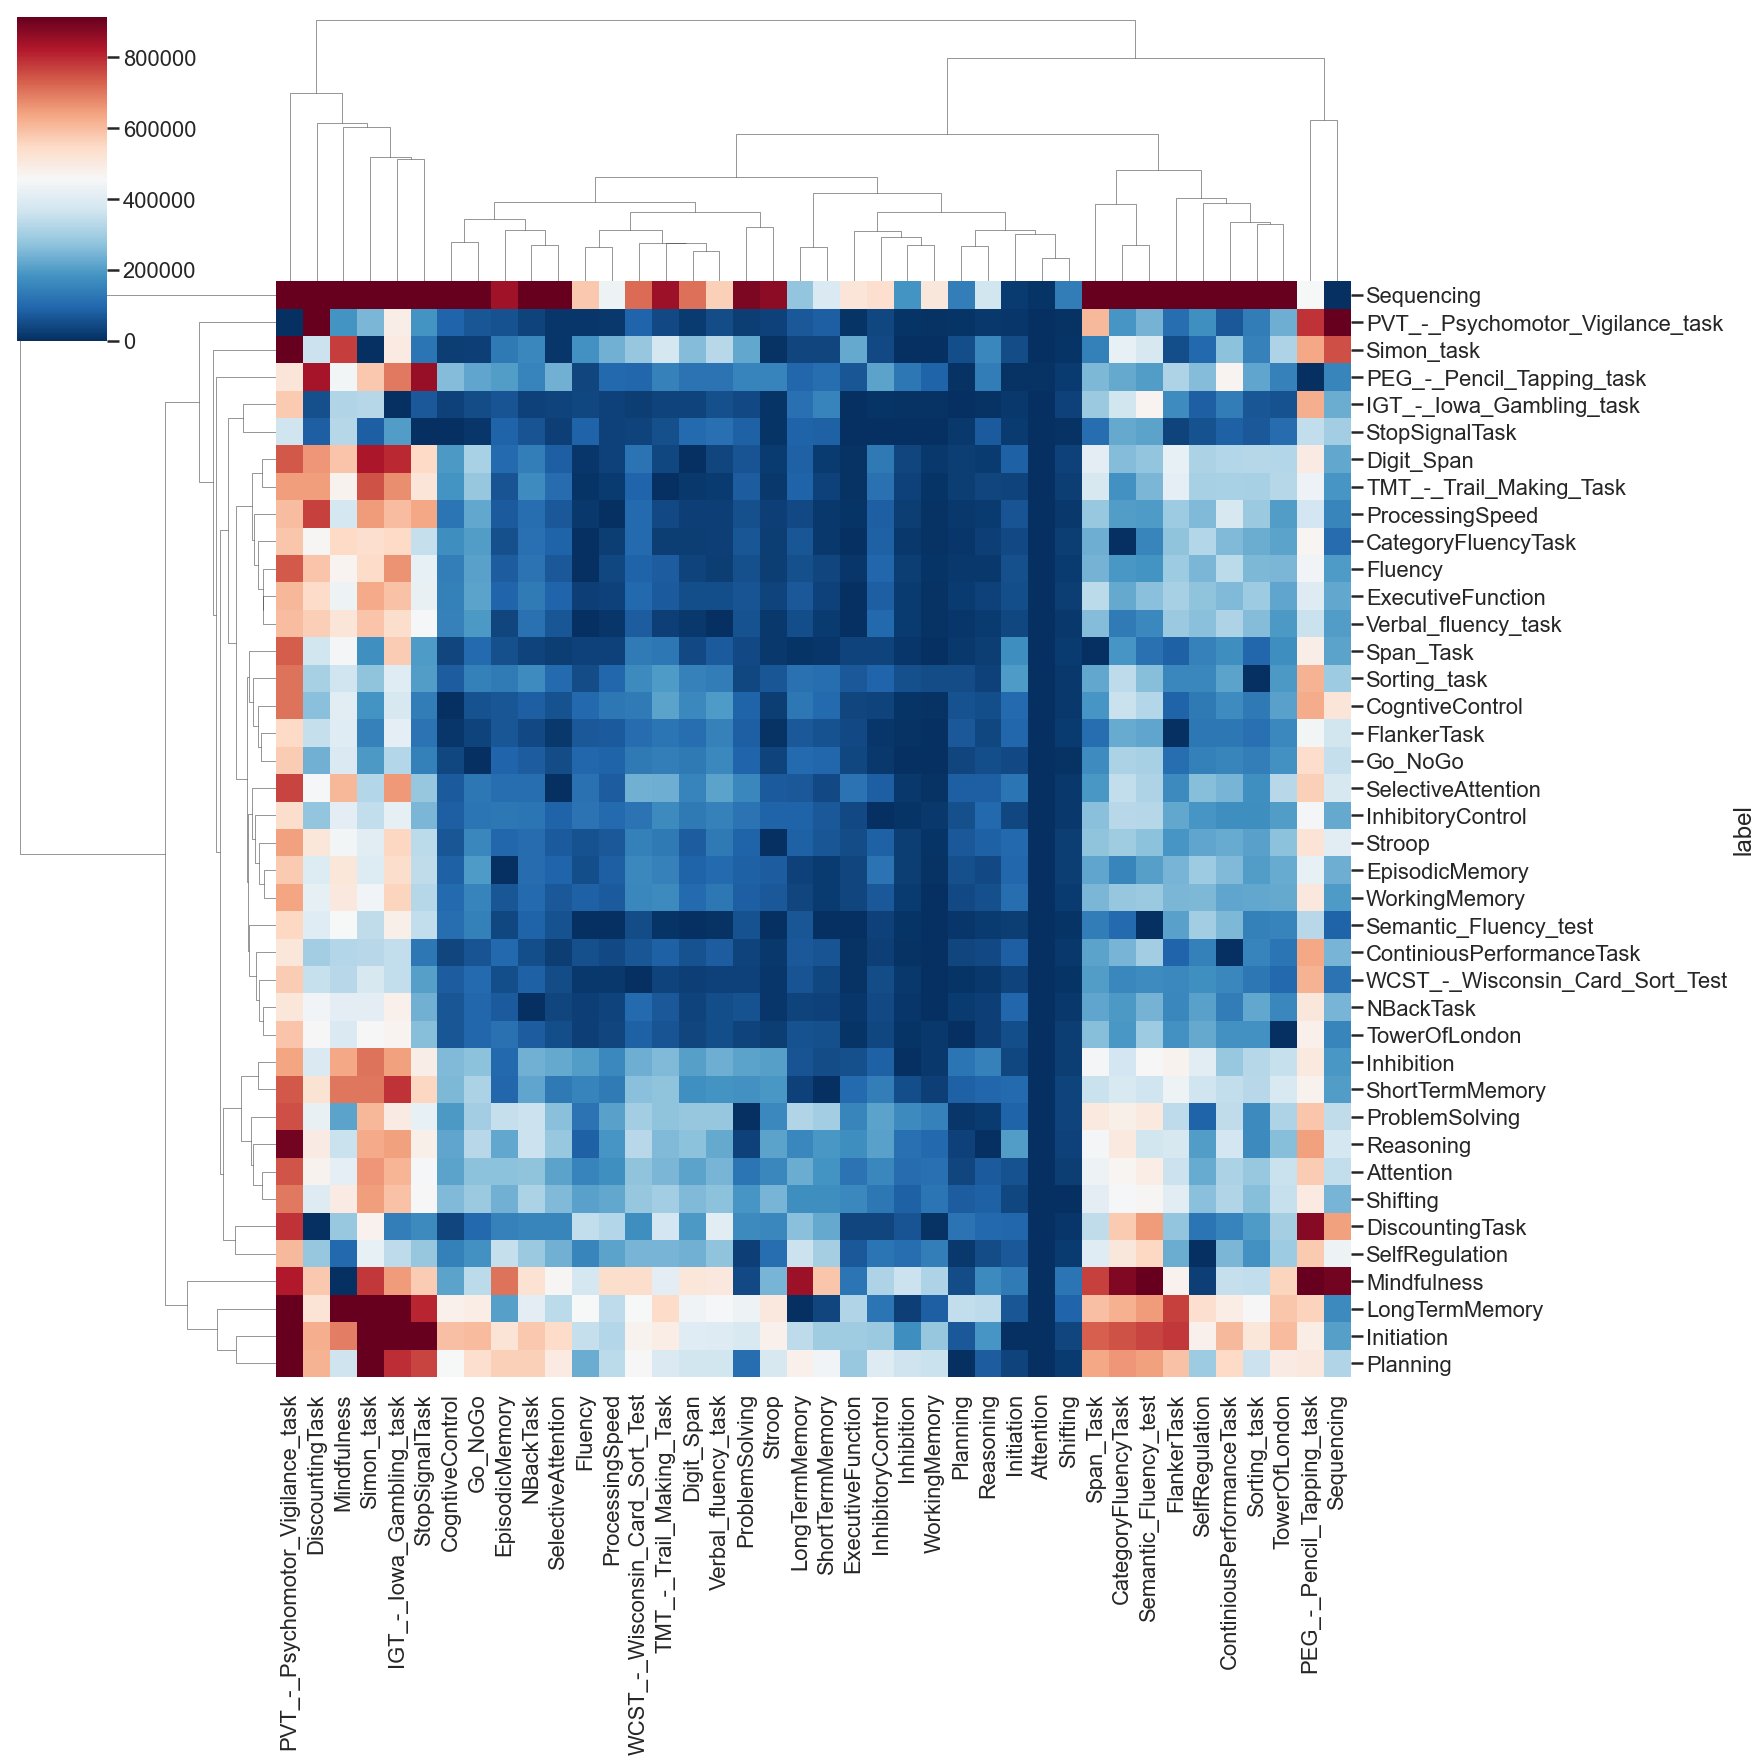

In [7]:
kl_losses = pd.read_csv('models/cogtext/multivariate_normal_kl_losses.csv',
                        index_col=0)
max_kl_loss = kl_losses.replace([np.inf],0).max().max()
kl_losses.replace([np.inf, np.nan], max_kl_loss, inplace=True)

rare_labels = pubmed.query('label not in @popular_labels')['label'].unique()
kl_losses.drop(index=rare_labels, columns=rare_labels, inplace=True, errors='ignore')

sns.clustermap(
  kl_losses,
  figsize=(25,25),
  cmap='RdBu_r', robust=True)

plt.show()


## Constructs

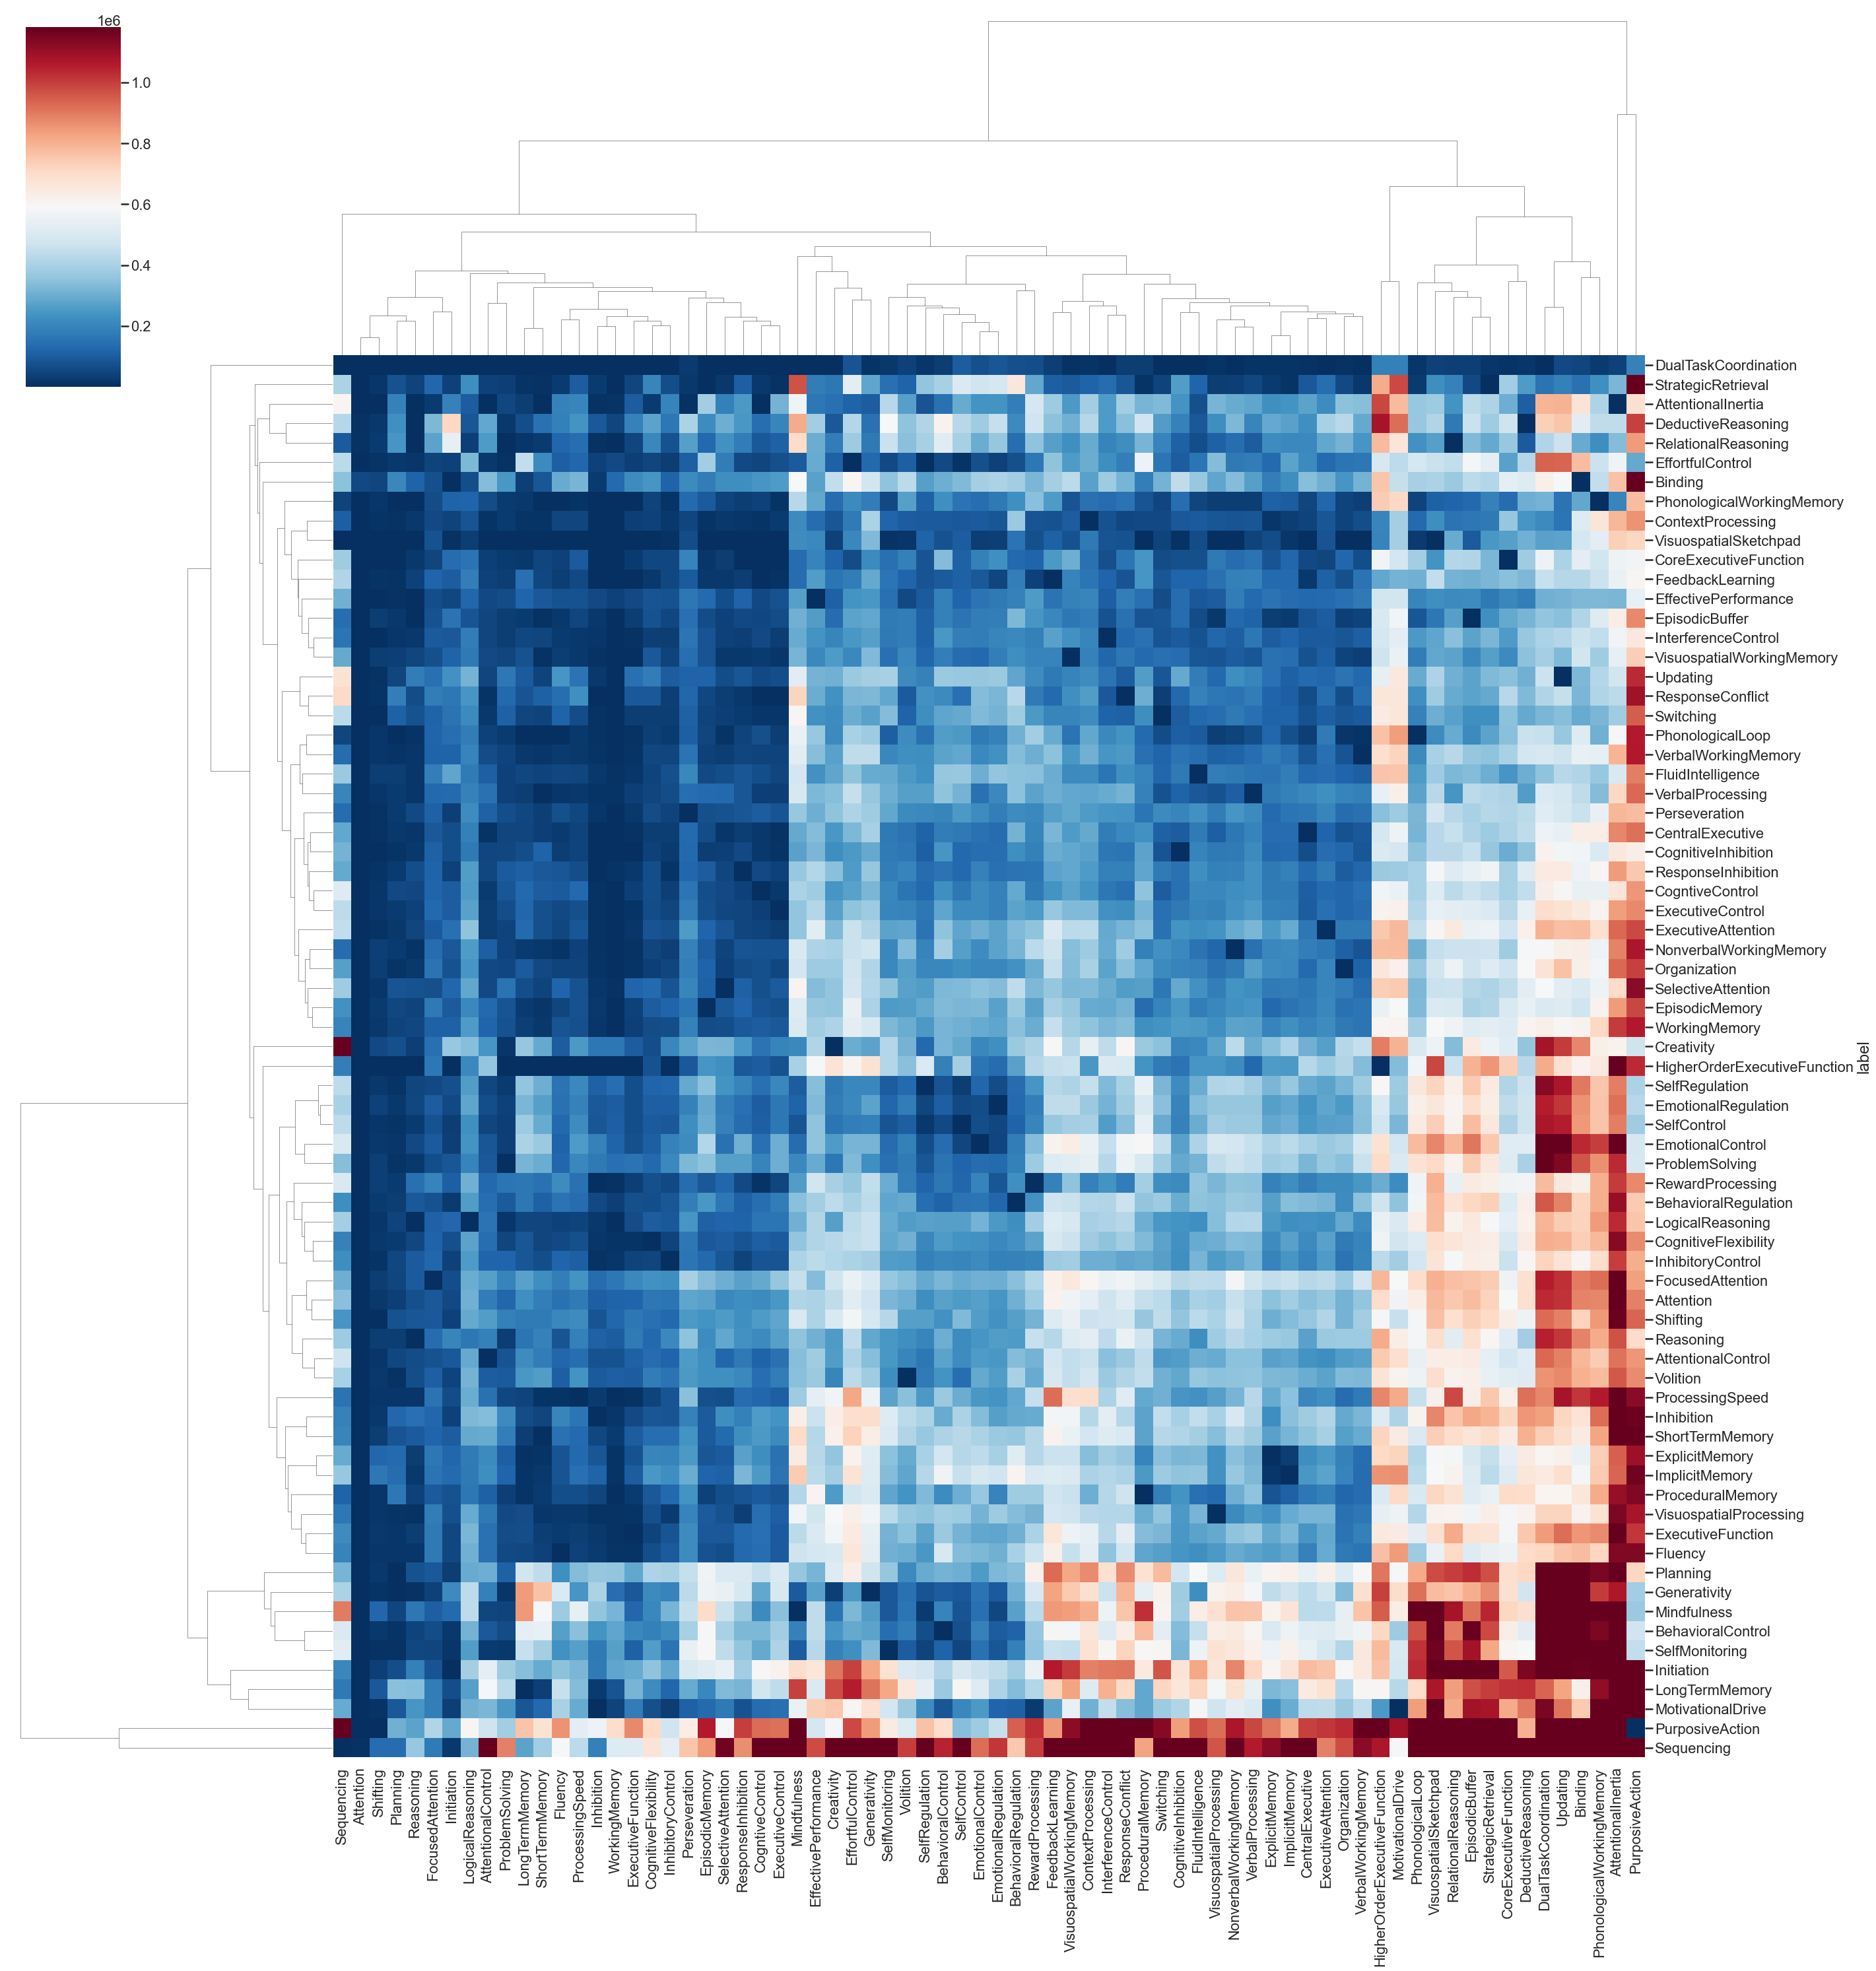

In [8]:
kl_losses = pd.read_csv('models/cogtext/multivariate_normal_kl_losses.csv',
                        index_col=0)


tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
kl_losses.drop(index=tasks, columns=tasks, inplace=True, errors='ignore')

sns.set('poster')
sns.clustermap(
  kl_losses.replace([np.inf, np.nan], 1000.0),
  figsize=(40,42),
  cmap='RdBu_r', robust=True)

plt.show()

dashbio.Clustergram(
  data=kl_losses.replace([np.inf, np.nan], 1000.0),
  column_labels=kl_losses.columns.to_list(),
  row_labels=kl_losses.index.to_list(),
  cluster='all',
  center_values=True,
  standardize=True,
  height=800,
  width=1000,
  display_ratio=[0.001, 0.001],
  color_map='RdBu_r',
  hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)

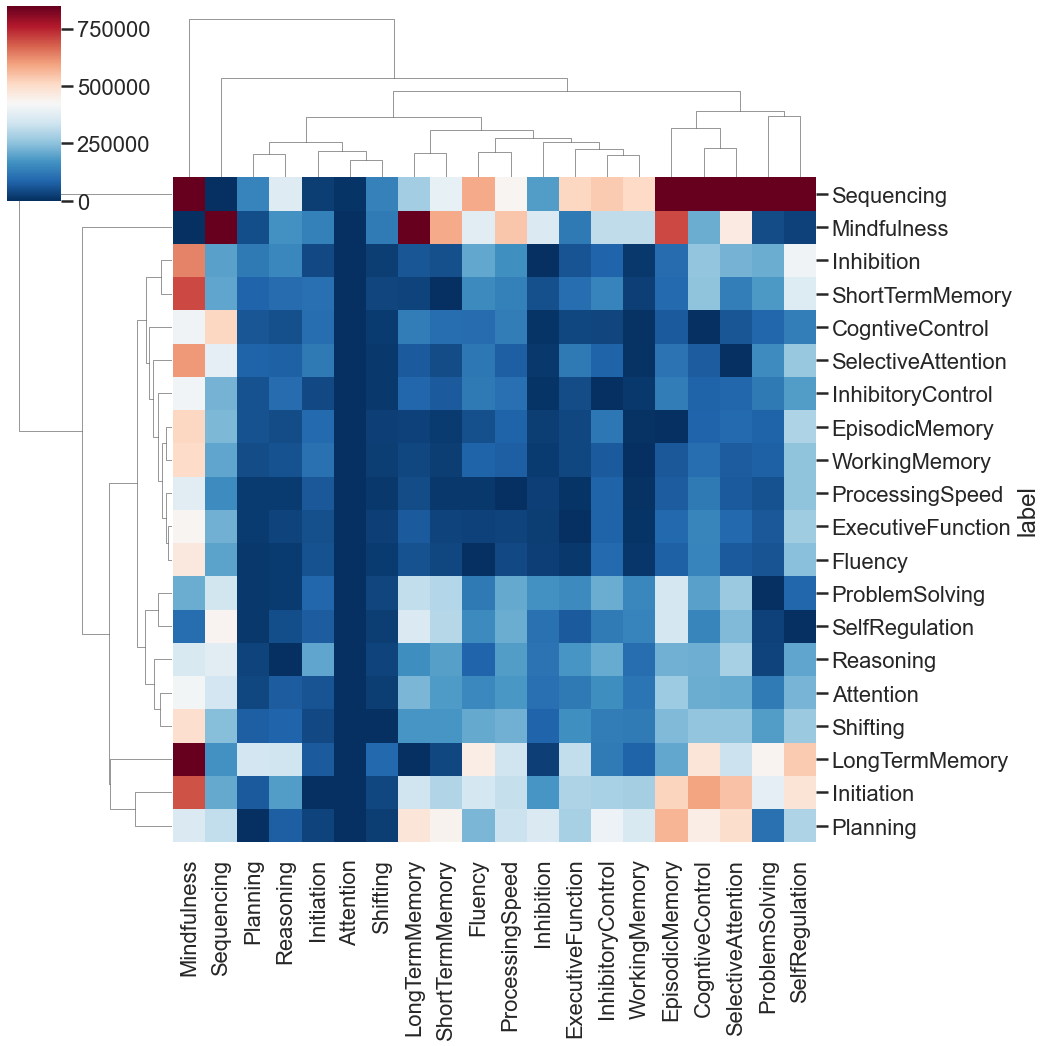

In [9]:
# popular constructs

kl_losses = pd.read_csv('models/cogtext/multivariate_normal_kl_losses.csv',
                        index_col=0)


tasks = pubmed.query('category.str.contains("Task")')['label'].unique()
kl_losses.drop(index=tasks, columns=tasks, inplace=True, errors='ignore')
kl_losses.drop(index=rare_labels, columns=rare_labels, inplace=True, errors='ignore')

sns.set('poster')
sns.clustermap(
  kl_losses.replace([np.inf, np.nan], 1000.0),
  figsize=(15,15),
  cmap='RdBu_r', robust=True)

plt.show()

## Tasks

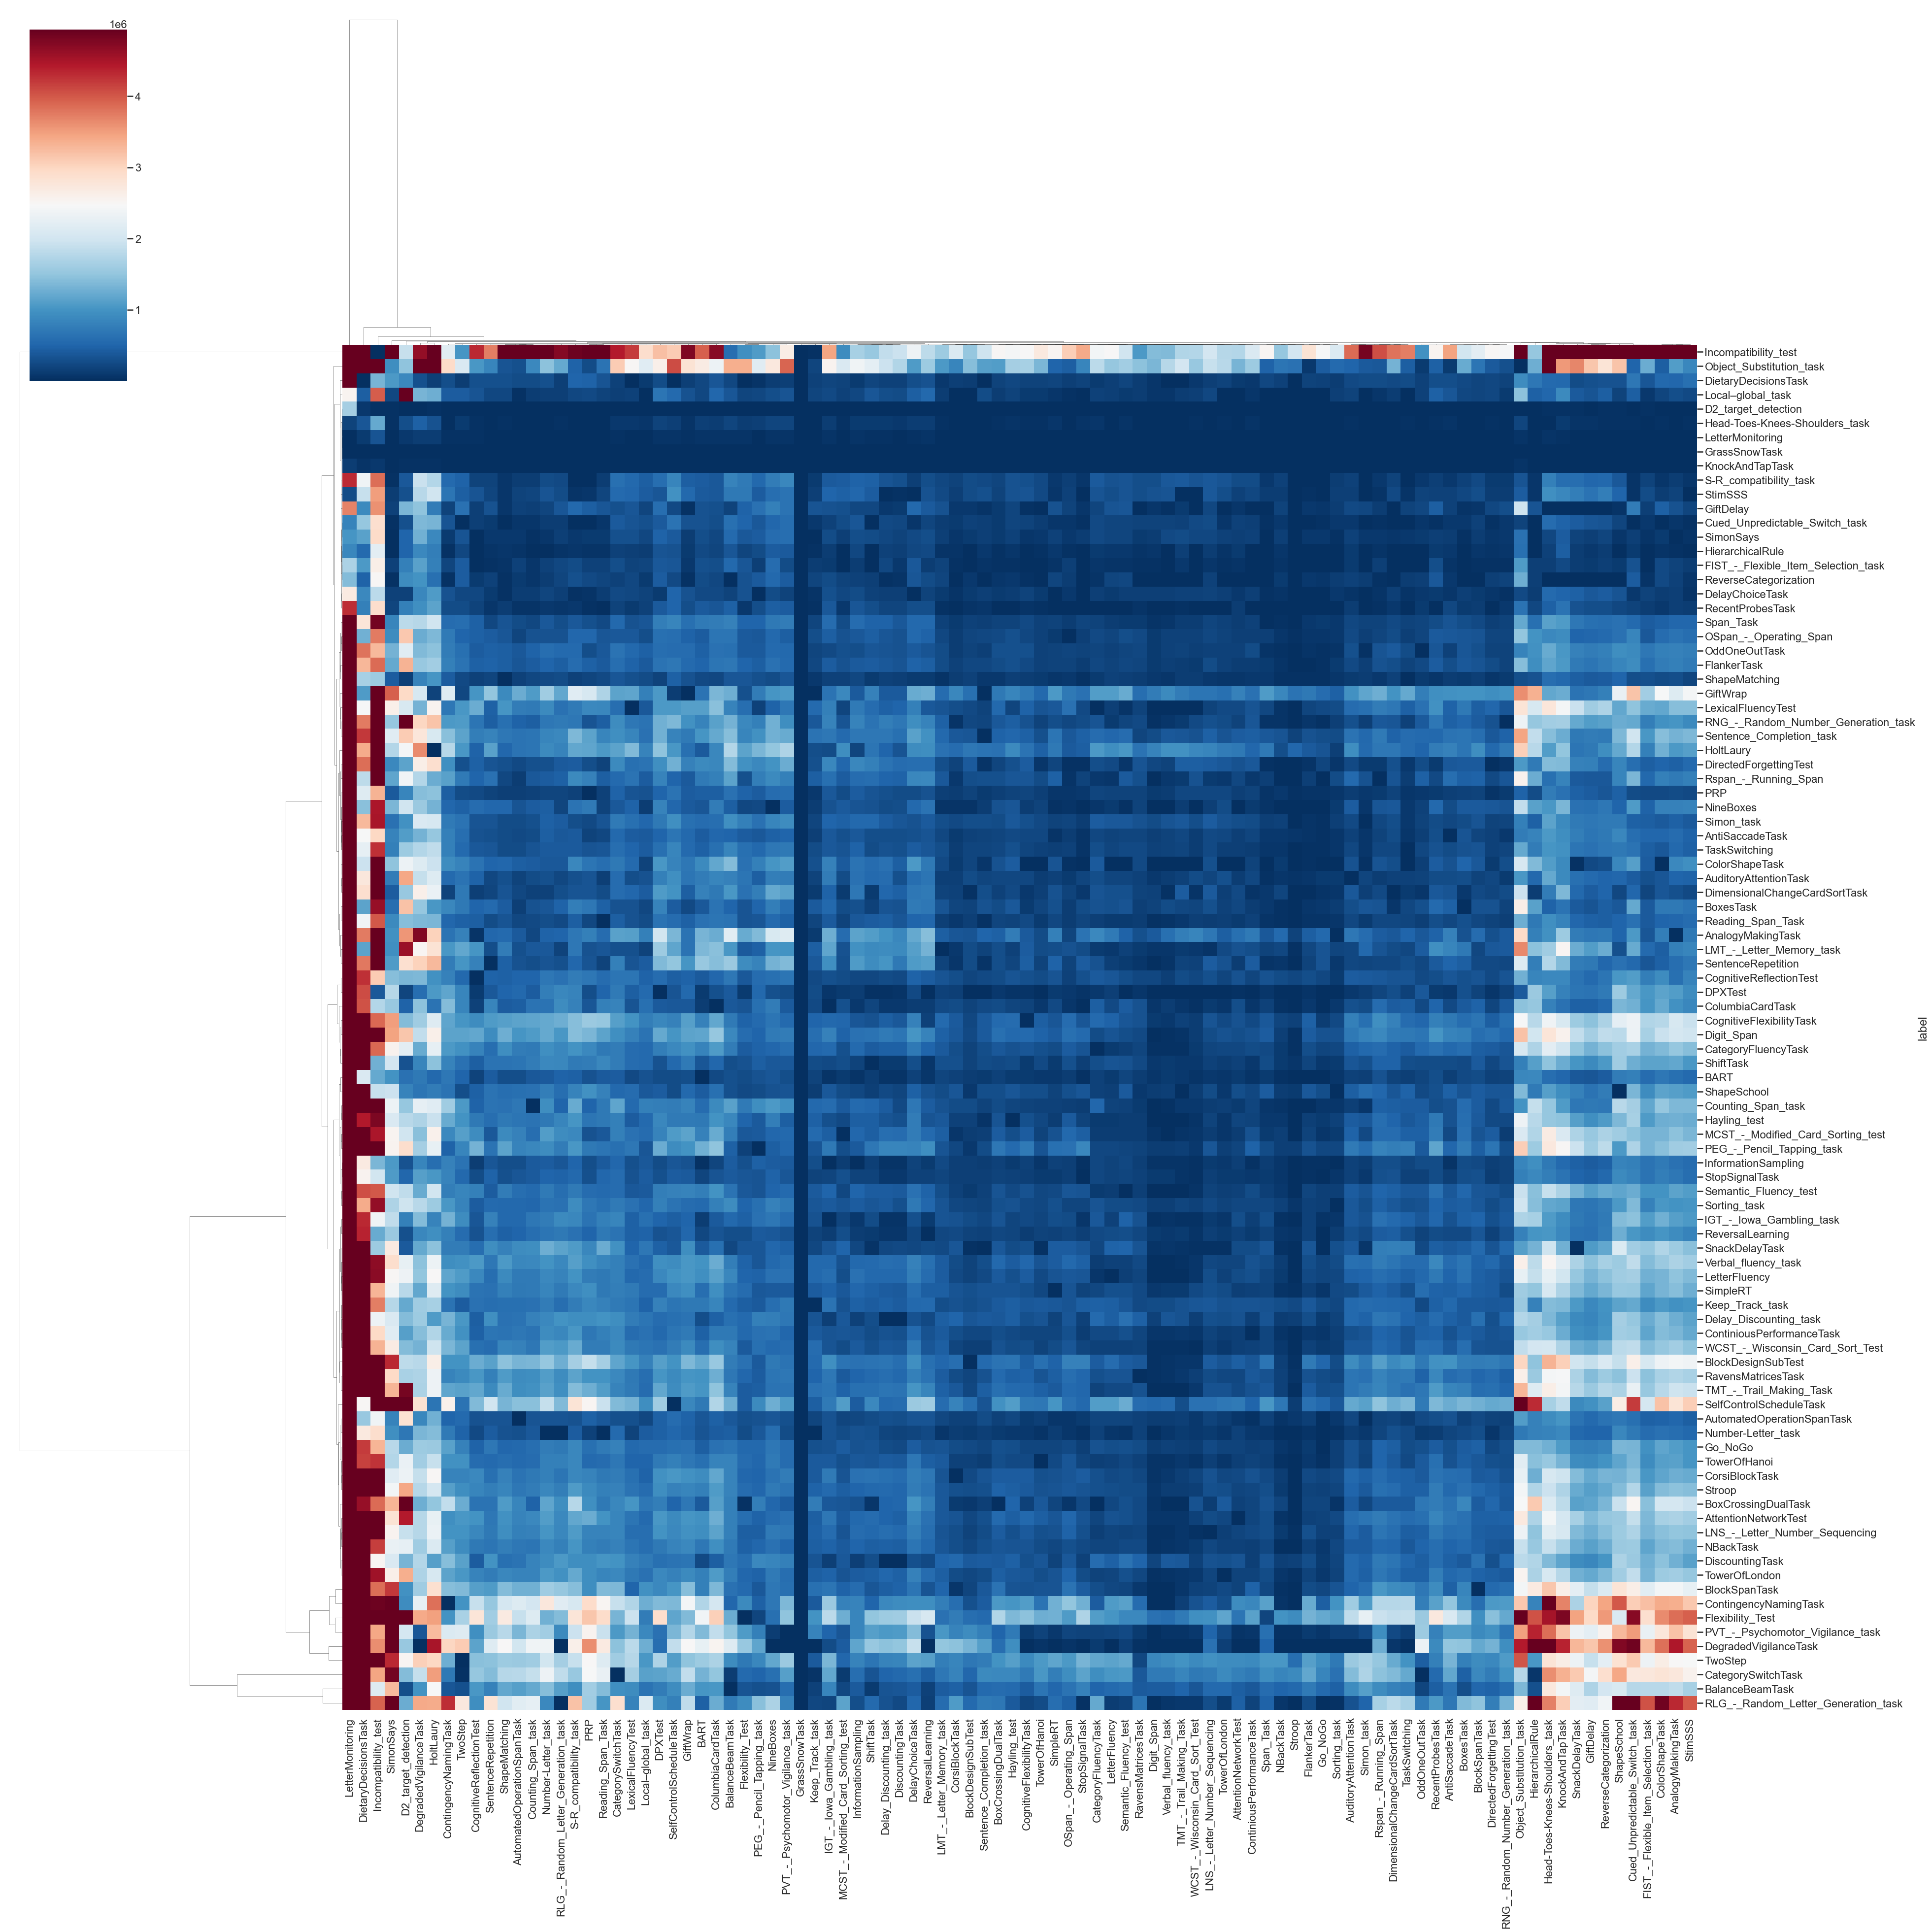

In [10]:
kl_losses = pd.read_csv('models/cogtext/multivariate_normal_kl_losses.csv',
                        index_col=0)


constructs = pubmed.query('category.str.contains("Construct")')['label'].unique()
kl_losses.drop(index=constructs, columns=constructs, inplace=True, errors='ignore')

sns.clustermap(
  kl_losses.replace([np.inf, np.nan], 1000.0),
  figsize=(55,55),
  cmap='RdBu_r', robust=True)

plt.show()